# PART 1 : BUILDING AND BAGGING A DECISION TREE
- Firstly , we create a class for making a decision tree , with functions defined to simulate the recursive binary splitting procedure
- Since this task requires us to classify input data into 2 categories, we choose the gini index to calculate the best possible split , minimizing it at every turn
- We implement 2 stopping conditions , the number of data points per region , and the maximum depth of tree , both of which are inputted when the class instance is created
- We make the decision tree which handles splitting based on both types of features : numerical and categorical
- numpy and pandas libraries have been used to work with input data , given in the form of a matrix
  

In [12]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
# creating the gini impurity function , for calulating gini index for a region
def gini(y):
    classes , counts = np.unique(y,return_counts = True)
    prob = counts/counts.sum()
    ans = 0
    for i in prob:
        ans+= (i*(1-i))
    return ans

## Making the DECISION TREE and training it on given dataset : Q3

In [14]:
# creating a decision tree
class DecisionTree_Classifier:
    def __init__(self,max_depth = 3,min_samples_region = 2):
        self.max_depth = max_depth
        self.min_samples_region = min_samples_region
        self.tree = None
    def best_split(self,X,y): # calculates best split given 1 region (splits it into 2)
        best_feature , value , best_gini , best_split = None , None , gini(y) , None
        for feature in X.columns:
            if X[feature].dtype == "object": #categorical feature
                values = X[feature].unique()
                for val in values:
                    left_mask = X[feature]==val
                    right_mask = ~left_mask
                    if left_mask.sum()<self.min_samples_region or right_mask.sum()<self.min_samples_region:
                        continue
                    left_gini = gini(y[left_mask])
                    right_gini = gini(y[right_mask])
                    overall_gini = (left_mask.sum()/len(y))*left_gini + (right_mask.sum()/len(y))*right_gini
                    if overall_gini <best_gini:
                        best_feature , value , best_gini  = feature , val , overall_gini
                        best_split = (X[left_mask], y[left_mask], X[right_mask], y[right_mask])
            else: #numerical feature
                sorted_f = X[feature].sort_values().unique()
                for i in range(len(sorted_f) -1):
                    val = (sorted_f[i] + sorted_f[i + 1]) / 2
                    left_mask = X[feature]<=val
                    right_mask = ~left_mask
                    if left_mask.sum()<self.min_samples_region or right_mask.sum()<self.min_samples_region:
                        continue
                    left_gini = gini(y[left_mask])
                    right_gini = gini(y[right_mask])
                    overall_gini = (left_mask.sum()/len(y))*left_gini + (right_mask.sum()/len(y))*right_gini
                    if overall_gini <best_gini:
                        best_feature , value , best_gini  = feature , val , overall_gini
                        best_split = (X[left_mask], y[left_mask], X[right_mask], y[right_mask])
        return best_feature , value , best_split
    def build_tree(self,X,y,depth = 0):
        best_feature, best_threshold, best_splits = self.best_split(X, y)
        if best_feature is None:
            return y.mode()[0]
        
        left_X, left_y, right_X, right_y = best_splits
        return {
            'feature': best_feature,
            'threshold': best_threshold,
            'left': self.build_tree(left_X, left_y, depth + 1),
            'right': self.build_tree(right_X, right_y, depth + 1)
        }
    def build_tree_rf(self,X,y,depth = 0):
        # choosing 2 random features (rf)
        features = X.columns.to_numpy()
        random_2_features = np.random.choice(features,size = 2 , replace = False)
        X_reduced = X[random_2_features]
        best_feature, best_threshold, best_splits = self.best_split(X_reduced, y)
        if best_feature is None:
            return y.mode()[0]
        
        left_X, left_y, right_X, right_y = best_splits
        # Recover full X using indices
        left_X = X.loc[left_X.index]  # Use the original X
        right_X = X.loc[right_X.index]
        return {
            'feature': best_feature,
            'threshold': best_threshold,
            'left': self.build_tree_rf(left_X, left_y, depth + 1),
            'right': self.build_tree_rf(right_X, right_y, depth + 1)
        }
        
    def train(self,X,y):
        self.tree = self.build_tree(X,y)
    def train_rf(self,X,y):
        self.tree = self.build_tree_rf(X,y)
    def predict_new_sample(self,x,node):
        if not isinstance(node,dict):
            return node #leaf reached
        if isinstance(node['threshold'],str): #categorical node
            if x[node['feature']] == node['threshold']:
                return self.predict_new_sample(x,node['left'])
            else:
                return self.predict_new_sample(x,node['right'])
        else:
            if x[node['feature']] <= node['threshold']:
                return self.predict_new_sample(x, node['left'])
            else:
                return self.predict_new_sample(x, node['right'])
        
        

In [15]:
data = pd.DataFrame({
    'Age': [25, 30, 35, 40, 45, 50, 55, 60],
    'Income': ['High', 'High', 'Medium', 'Low', 'Low', 'Low', 'Medium', 'High'],
    'Student': ['No', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No'],
    'Credit': ['Fair', 'Excellent', 'Fair', 'Fair', 'Fair', 'Excellent', 'Excellent', 'Fair'],
    'BuyComputer': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No']
})
X_train = data.drop(columns = ['BuyComputer'])
y_train = data['BuyComputer']

dt = DecisionTree_Classifier(max_depth = 3, min_samples_region = 2)
dt.train(X_train,y_train)
print(dt.tree)

{'feature': 'Income', 'threshold': 'High', 'left': 'No', 'right': {'feature': 'Age', 'threshold': 47.5, 'left': 'Yes', 'right': 'No'}}


### PREDICTION ON GIVEN TEST SAMPLE

In [16]:
test_x = {'Age': [42], 'Income': ['Low'], 'Student': ['No'], 'Credit': ['Excellent']}
ans = dt.predict_new_sample(test_x,dt.tree)
print(ans)

Yes


## BAGGING 10 TREES + USING ONLY 2 RANDOM FEATURES FOR EACH TREE : RANDOM FOREST : Q4

In [6]:
# creating a list of 10 dictionaries to store the 10 decision trees
bagging = [[0]*2 for _ in range(10)] 
for i in range(10):
    X_reduced = X_train
    # Sample rows with replacement (bootstrap sampling)
    sampled_indices = np.random.choice(X_reduced.index, size=len(X_reduced), replace=True)
    X_reduced = X_reduced.loc[sampled_indices]
    y_sampled = y_train.loc[sampled_indices]  # Align y_train with sampled X
    X_reduced = X_train.loc[sampled_indices].reset_index(drop=True)  # Reset index
    y_sampled = y_train.loc[sampled_indices].reset_index(drop=True)  # Reset index
    
    oob_indices = list(set(X_train.index) - set(sampled_indices))
    X_oob = X_train.loc[oob_indices]
    y_oob = y_train.loc[oob_indices]
    
    # Train the decision tree
    bagging[i][0] = DecisionTree_Classifier(max_depth=4, min_samples_region=2)
    bagging[i][0].train(X_reduced, y_sampled)
    bagging[i][1] = (X_oob,y_oob)
for i in range(10):
    print(bagging[i][0].tree)
    print()

{'feature': 'Income', 'threshold': 'High', 'left': 'No', 'right': {'feature': 'Age', 'threshold': 47.5, 'left': 'Yes', 'right': 'No'}}

{'feature': 'Income', 'threshold': 'Medium', 'left': 'Yes', 'right': 'No'}

{'feature': 'Income', 'threshold': 'Low', 'left': 'Yes', 'right': 'No'}

{'feature': 'Age', 'threshold': 32.5, 'left': 'No', 'right': 'Yes'}

{'feature': 'Age', 'threshold': 30.0, 'left': 'No', 'right': {'feature': 'Age', 'threshold': 47.5, 'left': 'Yes', 'right': 'No'}}

{'feature': 'Income', 'threshold': 'Medium', 'left': 'Yes', 'right': {'feature': 'Age', 'threshold': 45.0, 'left': 'No', 'right': 'No'}}

{'feature': 'Income', 'threshold': 'High', 'left': 'No', 'right': 'Yes'}

{'feature': 'Income', 'threshold': 'High', 'left': 'No', 'right': 'Yes'}

{'feature': 'Age', 'threshold': 32.5, 'left': 'No', 'right': {'feature': 'Age', 'threshold': 47.5, 'left': 'Yes', 'right': 'No'}}

{'feature': 'Income', 'threshold': 'High', 'left': 'No', 'right': 'Yes'}



In [7]:
# creating a list of 10 dictionaries to store the 10 decision trees
random_forest = [[0]*2 for _ in range(10)] 
for i in range(10):
    X_reduced = X_train
    # Sample rows with replacement (bootstrap sampling)
    sampled_indices = np.random.choice(X_reduced.index, size=len(X_reduced), replace=True)
    X_reduced = X_reduced.loc[sampled_indices]
    y_sampled = y_train.loc[sampled_indices]  # Align y_train with sampled X
    X_reduced = X_train.loc[sampled_indices].reset_index(drop=True)  # Reset index
    y_sampled = y_train.loc[sampled_indices].reset_index(drop=True)  # Reset index
    
    oob_indices = list(set(X_train.index) - set(sampled_indices))
    X_oob = X_train.loc[oob_indices]
    y_oob = y_train.loc[oob_indices]
    
    # Train the decision tree
    random_forest[i][0] = DecisionTree_Classifier(max_depth=4, min_samples_region=2)
    random_forest[i][0].train_rf(X_reduced, y_sampled)
    random_forest[i][1] = (X_oob,y_oob)
for i in range(10):
    print(random_forest[i][0].tree)
    print()

{'feature': 'Income', 'threshold': 'Medium', 'left': 'Yes', 'right': {'feature': 'Credit', 'threshold': 'Fair', 'left': 'No', 'right': 'No'}}

{'feature': 'Income', 'threshold': 'High', 'left': 'No', 'right': {'feature': 'Age', 'threshold': 47.5, 'left': 'Yes', 'right': 'No'}}

{'feature': 'Income', 'threshold': 'High', 'left': 'No', 'right': {'feature': 'Credit', 'threshold': 'Fair', 'left': 'Yes', 'right': 'Yes'}}

{'feature': 'Income', 'threshold': 'High', 'left': 'No', 'right': 'Yes'}

{'feature': 'Income', 'threshold': 'High', 'left': 'No', 'right': {'feature': 'Credit', 'threshold': 'Excellent', 'left': 'No', 'right': 'Yes'}}

{'feature': 'Age', 'threshold': 30.0, 'left': 'No', 'right': 'Yes'}

{'feature': 'Age', 'threshold': 32.5, 'left': 'No', 'right': {'feature': 'Student', 'threshold': 'No', 'left': 'Yes', 'right': 'No'}}

{'feature': 'Age', 'threshold': 45.0, 'left': {'feature': 'Age', 'threshold': 37.5, 'left': 'No', 'right': 'Yes'}, 'right': 'No'}

{'feature': 'Student', '

In [8]:
from collections import Counter
# defining function for bagged trees and input test sample to predict output
def predict_bag(random_forest,x):
    pred = [""]*len(random_forest)
    for i in range(len(random_forest)):
        pred[i] = random_forest[i][0].predict_new_sample(x,random_forest[i][0].tree)
    final_pred = Counter(pred).most_common(1)[0][0]
    print(pred)
    return final_pred
    

In [9]:
new_sample = {'Age': 49, 'Income': 'Low', 'Student': 'No', 'Credit': 'Excellent'}
prediction = predict_bag(random_forest, new_sample)
print("Final Prediction(rf) : ", prediction)
prediction = predict_bag(bagging, new_sample)

print("final prediction(bagging) : ",prediction)

['No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No']
Final Prediction(rf) :  No
['No', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes']
final prediction(bagging) :  No


## COMPUTING OUT OF BAG ERROR

In [10]:
oob_error = [0] * 10
# Function to compute the OOB error for each tree (random forest)
for i in range(10):
    tree = random_forest[i][0]  
    X_oob = random_forest[i][1][0]  
    y_oob = random_forest[i][1][1]     
    # Iterate over each OOB sample and predict using tree
    for j in range(len(X_oob)):
        # Predict the class for the current OOB sample
        predicted_class = tree.predict_new_sample(X_oob.iloc[j], tree.tree)
        # Compare with the true label
        if predicted_class != y_oob.iloc[j]:
            oob_error[i] += 1
    oob_error[i] = oob_error[i] / len(X_oob)
for i in range(10):
    print(f"OOB error for tree {i}: {oob_error[i]:.4f}")
print()
print("AVG OOB ERROR(RANDOM FOREST) :" , sum(oob_error)/len(oob_error))

OOB error for tree 0: 0.2500
OOB error for tree 1: 0.5000
OOB error for tree 2: 0.0000
OOB error for tree 3: 0.5000
OOB error for tree 4: 0.5000
OOB error for tree 5: 0.6667
OOB error for tree 6: 1.0000
OOB error for tree 7: 0.3333
OOB error for tree 8: 1.0000
OOB error for tree 9: 0.3333

AVG OOB ERROR(RANDOM FOREST) : 0.5083333333333333


In [11]:
oob_error = [0] * 10
# Function to compute the OOB error for each tree (random forest)
for i in range(10):
    tree = bagging[i][0]  
    X_oob = bagging[i][1][0]  
    y_oob = bagging[i][1][1]     
    # Iterate over each OOB sample and predict using tree
    for j in range(len(X_oob)):
        # Predict the class for the current OOB sample
        predicted_class = tree.predict_new_sample(X_oob.iloc[j], tree.tree)
        # Compare with the true label
        if predicted_class != y_oob.iloc[j]:
            oob_error[i] += 1
    oob_error[i] = oob_error[i] / len(X_oob)
for i in range(10):
    print(f"OOB error for tree {i}: {oob_error[i]:.4f}")
print()
print("AVG OOB ERROR(BAGGING) :" , sum(oob_error)/len(oob_error))

ZeroDivisionError: division by zero

## PART 2 : PERFORMING POLYNOMIAL REGRESSION USING CROSS VALIDATION : Q5

In [12]:
# producing data
# Set seed for reproducibility
np.random.seed(42)
x = np.linspace(0, 2 * np.pi, 100)
noise = np.random.normal(0, 0.1, size=x.shape)
y = np.sin(x) + noise

In [13]:
def cross_val(X,y,seed,k = 5):
    fold_size = X.shape[0]//k
    np.random.seed(seed)
    ind = np.arange(X.shape[0])
    np.random.shuffle(ind)
    X_shuff = X[ind]
    y_shuff = y[ind]
    folds = []
    for i in range(k):
        start = i*fold_size
        end = start + fold_size
        folds.append((X_shuff[start:end],y_shuff[start:end]))
    return folds

In [14]:
def eval_train_test_error(folds):
    avg_train_error = 0
    avg_test_error = 0
    for i in range(len(folds)): #hold ith fold , use rest for training
        test_X,test_y = folds[i]
        train_X = np.vstack([folds[j][0] for j in range(len(folds)) if j != i])
        train_y = np.hstack([folds[j][1] for j in range(len(folds)) if j != i])
        W = np.linalg.inv(train_X.T @ train_X) @ train_X.T @ train_y
        avg_train_error += np.mean((train_y - train_X@W)**2)
        avg_test_error += np.mean((test_y - test_X@W)**2)
    avg_train_error/=len(folds)
    avg_test_error/=len(folds)
    return avg_train_error,avg_test_error,W

In [15]:
# creating and evaluation of models
models = [0] * 4
x_reshape = x.reshape(-1, 1)  # (100,1)
# 1-degree
X_1 = np.c_[x_reshape, np.ones((x_reshape.shape[0], 1))]
models[0] = eval_train_test_error(cross_val(X_1,y,42,5))
# 2-degree
X_2 = np.c_[x_reshape ** 2, x_reshape, np.ones((x_reshape.shape[0], 1))]
models[1] = eval_train_test_error(cross_val(X_2,y,42,5))
# 3-degree
X_3 = np.c_[x_reshape ** 3, x_reshape ** 2, x_reshape, np.ones((x_reshape.shape[0], 1))]
models[2] = eval_train_test_error(cross_val(X_3,y,42,5))
# 4-degree
X_4 = np.c_[x_reshape ** 4, x_reshape ** 3, x_reshape ** 2, x_reshape, np.ones((x_reshape.shape[0], 1))]
models[3] = eval_train_test_error(cross_val(X_4,y,42,5))

In [16]:
for i in range(4):
    print("Degree :", i+1 ,"-")
    print("Avg training error : " , models[i][0])
    print("Avg validation error : " , models[i][1])

Degree : 1 -
Avg training error :  0.19342695919042815
Avg validation error :  0.19748264839776103
Degree : 2 -
Avg training error :  0.19082021515798658
Avg validation error :  0.2225628759617428
Degree : 3 -
Avg training error :  0.012526400645691072
Avg validation error :  0.01409431022268342
Degree : 4 -
Avg training error :  0.012328449292436072
Avg validation error :  0.015454564246899496


### based off of these error metrics , we conclude that degree 3 is the polynomial degree to be used 

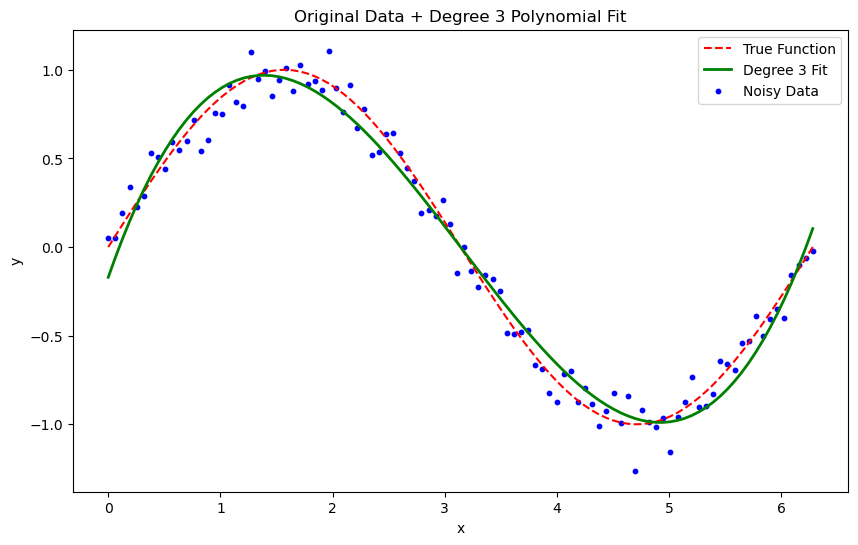

In [17]:
# Generate x values
x_smooth = x.reshape(-1,1)

# Create polynomial features for degree 3
X_poly = np.c_[x_smooth ** 3, x_smooth ** 2, x_smooth, np.ones((x_smooth.shape[0], 1))]

# Extract the weight vector for degree 3 polynomial
W = models[2][2]  # Index 2 corresponds to degree 3

# Compute predictions
y_pred = X_poly @ W

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label="Noisy Data", color='b', s=10)  # Noisy Data
plt.plot(x, np.sin(x), label="True Function", color='r', linestyle="dashed")  # True Function
plt.plot(x_smooth, y_pred, color="green", label="Degree 3 Fit", linewidth=2)  # Degree 3 polynomial

# Customize plot
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Original Data + Degree 3 Polynomial Fit")
plt.show()